Files already downloaded and verified


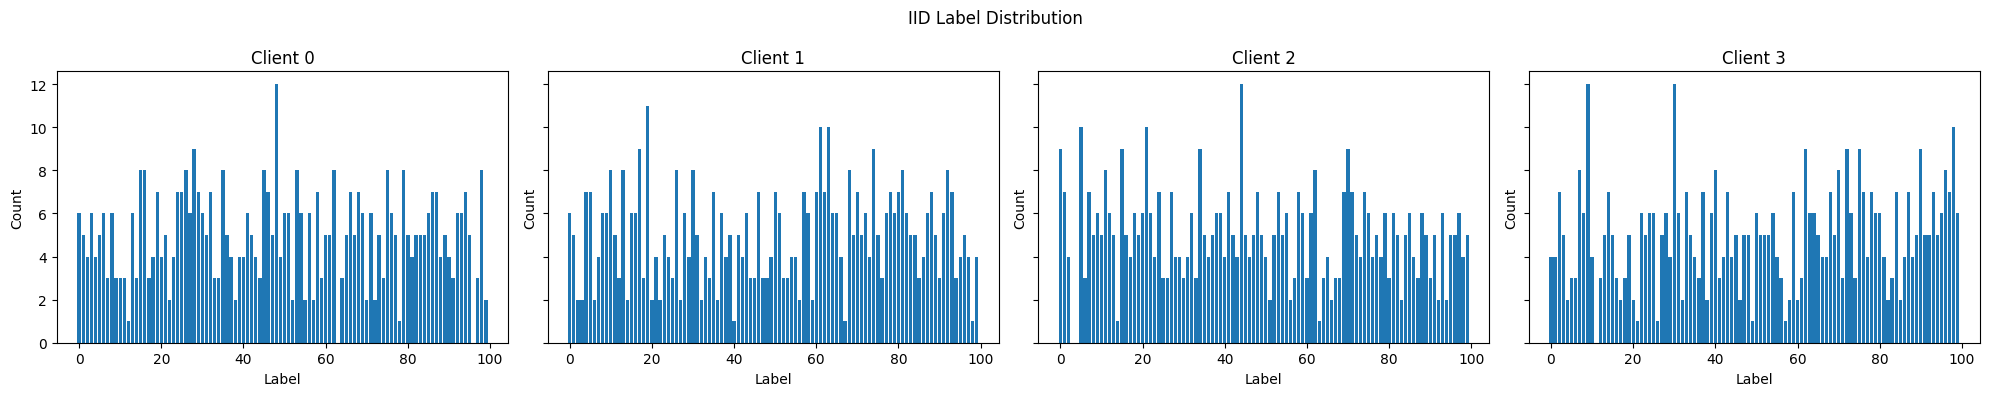

[Non-IID] samples_per_client: 500
[Non-IID] samples_per_label: 100


Non-IID Splitting: 100%|██████████| 100/100 [00:00<00:00, 158.73it/s]


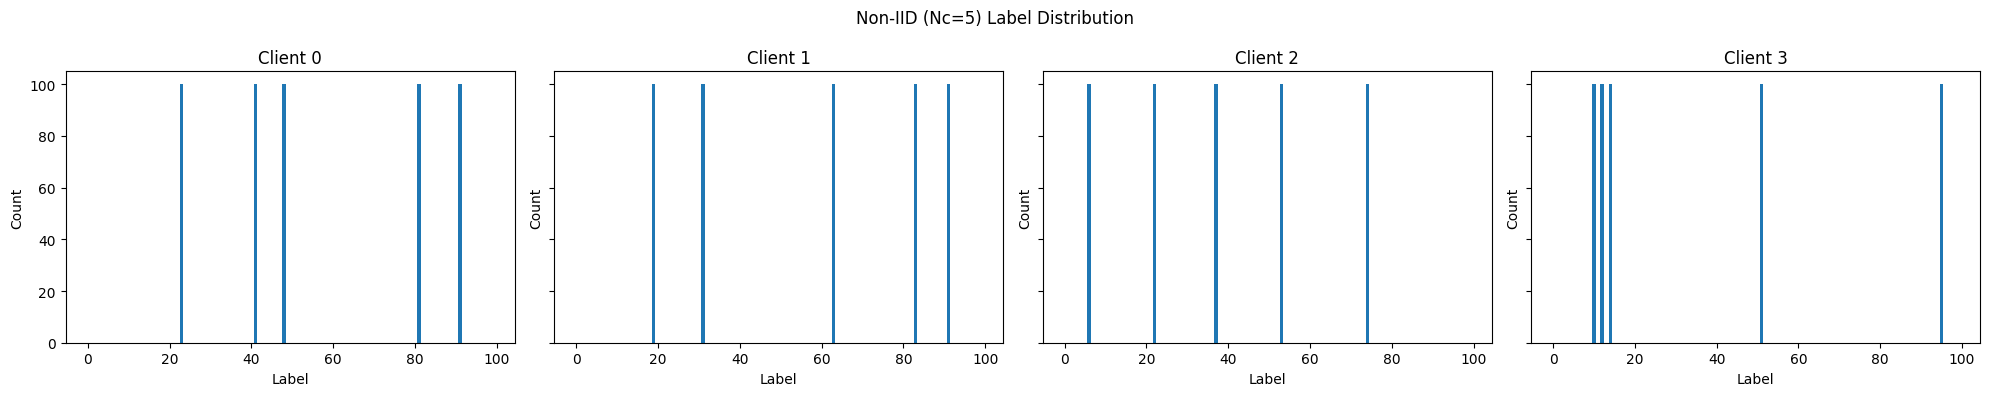

In [1]:
import torch
import pandas as pd
import numpy as np
import random
from torch.utils.data import Subset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

class DatasetSharder:
    """
    Creates IID or Non-IID shards for a dataset.
    Non-IID logic is adapted from your snippet:
      - Sort the dataset by label (for clarity).
      - Use a DataFrame to manage the data.
      - Each client c picks n_labels at random from what's left,
        samples ~samples_per_label from each label, and removes them from the global pool.
      - Some label overlap across clients can happen (since each client picks from the
        remaining labels randomly).
    """

    def __init__(self, dataset, K, shard_type='iid', n_labels=5):
        """
        Args:
            dataset: A PyTorch dataset (e.g. torchvision.datasets.CIFAR100)
            K: Number of clients
            shard_type: 'iid' or 'non_iid'
            n_labels: For non-iid, how many labels each client should pick
        """
        self.dataset = dataset
        self.K = K
        self.shard_type = shard_type
        self.n_labels = n_labels

    def shard_dataset(self):
        """
        Main entry point. Returns a list of K Subset objects, one for each client.
        """
        if self.shard_type == 'iid':
            return self.iid_split()
        elif self.shard_type == 'non_iid':
            return self.non_iid_split()
        else:
            raise ValueError(f"Unsupported shard_type: {self.shard_type}")

    def iid_split(self):
        """
        IID partition:
          - Randomly splits the dataset into K roughly equal parts.
        """
        dataset_size = len(self.dataset)
        samples_per_client = dataset_size // self.K

        # Distribute remainder if not perfectly divisible
        lengths = [samples_per_client] * self.K
        remainder = dataset_size - (samples_per_client * self.K)
        for i in range(remainder):
            lengths[i] += 1

        subsets = random_split(self.dataset, lengths)
        return list(subsets)

    def non_iid_split(self):
        """
        Non-IID partition adapted from your snippet:
          - Sort the dataset by label, store in a DataFrame.
          - For each client c:
             1) Randomly picks self.n_labels from the unique labels in the leftover data
             2) For each chosen label, sample ~samples_per_label from that label
             3) Remove those samples from the global DataFrame
          - Allows label overlap across clients if the random choice repeats a label
            (and if there's still leftover samples for that label).
        """
        dataset_size = len(self.dataset)
        samples_per_client = dataset_size // self.K
        print(f"[Non-IID] samples_per_client: {samples_per_client}")

        # Build list of (original_index, (image, label))
        enumerated_data = list(enumerate(self.dataset))
        # Sort by label => enumerated_data[i][1][1] is the label
        enumerated_data.sort(key=lambda x: x[1][1])

        # Convert to DataFrame: columns=[orig_idx, img, targets]
        rows = []
        for (orig_idx, (img, label)) in enumerated_data:
            rows.append((orig_idx, img, label))
        df = pd.DataFrame(rows, columns=["orig_idx", "img", "targets"])

        # ~samples per label for each client
        samples_per_label = samples_per_client // self.n_labels
        print(f"[Non-IID] samples_per_label: {samples_per_label}")

        # If we can't even assign 1 sample per label, raise an error (or handle differently)
        if samples_per_label < 1:
            raise ValueError(
                f"non_iid_split: samples_per_label={samples_per_label} < 1.\n"
                "K or n_labels might be too large for the dataset size."
            )

        clients_subsets = []

        for c in tqdm(range(self.K), desc="Non-IID Splitting"):
            client_rows = []
            # All unique labels left in df
            available_labels = list(df["targets"].unique())
            # Shuffle them and pick n_labels
            np.random.shuffle(available_labels)
            chosen_labels = available_labels[:self.n_labels]

            for label in chosen_labels:
                label_data = df[df["targets"] == label]

                if len(label_data) >= samples_per_label:
                    sampled = label_data.sample(samples_per_label)
                    client_rows.extend(sampled.values.tolist())
                    df = df.drop(sampled.index)

                    # If leftover < samples_per_label, take them all
                    leftover_label_data = df[df["targets"] == label]
                    if len(leftover_label_data) < samples_per_label:
                        client_rows.extend(leftover_label_data.values.tolist())
                        df = df.drop(leftover_label_data.index)
                else:
                    # Not enough data for this label => take it all
                    client_rows.extend(label_data.values.tolist())
                    df = df.drop(label_data.index)

            # Build a Subset from these rows
            client_indices = [row[0] for row in client_rows]  # first column is orig_idx
            subset_for_client = Subset(self.dataset, client_indices)
            clients_subsets.append(subset_for_client)

        return clients_subsets

def plot_label_distribution(client_datasets, num_classes=100, title="Label Distribution", max_clients_to_plot=4):
    """
    Plots the label distribution for up to `max_clients_to_plot` clients.
    Each 'client_datasets[i]' is a Subset of the original dataset.
    """
    num_clients_to_plot = min(len(client_datasets), max_clients_to_plot)
    fig, axes = plt.subplots(1, num_clients_to_plot, figsize=(5 * num_clients_to_plot, 4), sharey=True)
    if num_clients_to_plot == 1:
        axes = [axes]

    for i in range(num_clients_to_plot):
        subset_indices = client_datasets[i].indices
        # Gather labels
        labels = [client_datasets[i].dataset[idx][1] for idx in subset_indices]
        label_counts = [0]*num_classes
        for lab in labels:
            label_counts[lab] += 1

        axes[i].bar(range(num_classes), label_counts)
        axes[i].set_title(f"Client {i}")
        axes[i].set_xlabel("Label")
        axes[i].set_ylabel("Count")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def main():
    # Example: Let's use K=4 just for a quick demonstration
    # (You can set K=100 if you wish, but plotting distribution for 100 clients can be large)
    K = 100
    n_labels = 5  # for non-iid

    # Fix seeds for reproducibility
    random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    # Load CIFAR-100 (train set)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
    ])
    trainset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)

    # --------------------------------------------------------------------
    # 1. IID Sharding
    # --------------------------------------------------------------------
    iid_sharder = DatasetSharder(dataset=trainset, K=K, shard_type='iid')
    iid_client_datasets = iid_sharder.shard_dataset()

    # Plot IID distribution for the first few clients
    plot_label_distribution(
        iid_client_datasets,
        num_classes=100,
        title="IID Label Distribution",
        max_clients_to_plot=4
    )

    # --------------------------------------------------------------------
    # 2. Non-IID Sharding
    # --------------------------------------------------------------------
    non_iid_sharder = DatasetSharder(dataset=trainset, K=K, shard_type='non_iid', n_labels=n_labels)
    non_iid_client_datasets = non_iid_sharder.shard_dataset()

    # Plot Non-IID distribution for the first few clients
    plot_label_distribution(
        non_iid_client_datasets,
        num_classes=100,
        title=f"Non-IID (Nc={n_labels}) Label Distribution",
        max_clients_to_plot=4
    )

if __name__ == "__main__":
    main()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import copy
import random
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

# If you have a separate dataset_sharder.py, import it here:
# from dataset_sharder import DatasetSharder


class EnhancedLeNet(nn.Module):
    def __init__(self):
        super(EnhancedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x



class FedAvg:
    def __init__(self, config, model, client_datasets, test_loader):
        self.config = config
        self.global_model = model
        self.client_datasets = client_datasets
        self.test_loader = test_loader
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.global_model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.num_clients = config['num_clients']

    def client_update(self, client_model, optimizer, train_loader):
        client_model.train()
        for epoch in range(self.config['local_epochs']):
            for data, target in train_loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = client_model(data)
                loss = self.criterion(output, target)
                loss.backward()
                optimizer.step()
        return client_model.state_dict()

    def aggregate(self, client_weights):
        global_weights = copy.deepcopy(client_weights[0])
        for key in global_weights.keys():
            for i in range(1, len(client_weights)):
                global_weights[key] += client_weights[i][key]
            global_weights[key] = torch.div(global_weights[key], len(client_weights))
        return global_weights

    def test(self):
        """Returns only test accuracy (no test loss is tracked)."""
        self.global_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.global_model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = 100.0 * correct / total
        return accuracy  # Not returning loss anymore

    def run(self):
        """Trains for config['rounds'], returning only accuracies + rounds_list."""
        num_selected = max(1, int(self.config['client_fraction'] * self.num_clients))
        test_accuracies = []
        rounds_list = []

        for round_ in tqdm(range(self.config['rounds']), desc="Federated Training Rounds"):
            # 1) Randomly select a subset of clients
            selected_clients = random.sample(range(self.num_clients), num_selected)
            client_weights = []

            # 2) Each selected client trains locally
            for client_idx in selected_clients:
                local_model = copy.deepcopy(self.global_model)
                local_model.to(self.device)
                optimizer = optim.SGD(local_model.parameters(),
                                      lr=self.config['lr'],
                                      momentum=0.9,
                                      weight_decay=0.0004)

                client_dataset = self.client_datasets[client_idx]
                train_loader = DataLoader(
                    client_dataset,
                    batch_size=self.config['batch_size'],
                    shuffle=True
                )

                local_weights = self.client_update(local_model, optimizer, train_loader)
                client_weights.append(local_weights)

            # 3) Aggregate local updates => new global model
            global_weights = self.aggregate(client_weights)
            self.global_model.load_state_dict(global_weights)

            # 4) Evaluate every 'test_freq' rounds (or round 0)
            if (round_ + 1) % self.config['test_freq'] == 0 or round_ == 0:
                accuracy = self.test()
                test_accuracies.append(accuracy)
                rounds_list.append(round_ + 1)
                print(f"Round {round_+1} => Test Accuracy: {accuracy:.2f}%")

        return test_accuracies, rounds_list


def main():
    # Hyperparameters
    K = 100
    C = 0.1
    N = 500  # total rounds
    J = 16   # local epochs
    lr = 0.01
    B = 64
    test_freq = 10

    random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load CIFAR-100
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409),
                             (0.2673, 0.2564, 0.2761))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409),
                             (0.2673, 0.2564, 0.2761))
    ])

    trainset = datasets.CIFAR100(root='./data', train=True,
                                 download=True, transform=transform_train)
    testset = datasets.CIFAR100(root='./data', train=False,
                                download=True, transform=transform_test)
    test_loader = DataLoader(testset, batch_size=B, shuffle=False, num_workers=2)



    # Example non-IID scenario (n_labels=5) plus IID scenario:
    scenarios = [
        ('iid', None),
        ('non_iid', 1),
        ('non_iid', 5),
        ('non_iid', 10),
        ('non_iid', 50)
    ]

    def run_fedavg(shard_type, n_labels=5):
        # Build the client datasets
        sharder = DatasetSharder(trainset, K=K, shard_type=shard_type, n_labels=n_labels)
        client_datasets = sharder.shard_dataset()

        # FedAvg config
        fed_config = {
            'num_clients': K,
            'client_fraction': C,
            'rounds': N,
            'local_epochs': J,
            'lr': lr,
            'batch_size': B,
            'test_freq': test_freq
        }

        global_model = EnhancedLeNet().to(device)
        fedavg = FedAvg(fed_config, global_model, client_datasets, test_loader)

        scenario_name = shard_type if shard_type == 'iid' else f"non_iid_{n_labels}"
        print(f"\n--- Shard config: {scenario_name} ---")
        test_accs, rounds_list = fedavg.run()
        return test_accs, rounds_list

    # Collect results
    all_accuracies = {}
    all_rounds = {}

    for (typ, nl) in scenarios:
        scenario_key = typ if typ == 'iid' else f"non_iid_Nc{nl}"
        if typ == 'iid':
            test_accs, rounds_list = run_fedavg('iid')
        else:
            test_accs, rounds_list = run_fedavg('non_iid', n_labels=nl)

        all_accuracies[scenario_key] = test_accs
        all_rounds[scenario_key] = rounds_list

    # Plot in high quality
    plt.figure(figsize=(10, 6))  # bigger figure
    for scenario_name in all_accuracies:
        plt.plot(all_rounds[scenario_name], all_accuracies[scenario_name], label=scenario_name)

    plt.title("FedAvg Accuracy: IID vs Non-IID (Nc=1,5,10,50)")
    plt.xlabel("Round")
    plt.ylabel("Test Accuracy (%)")
    plt.legend()
    plt.grid(True)

    # Use high DPI for clearer image in LaTeX
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    fname = f"comparison_{timestamp}.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved to {fname}")
    plt.show()


if __name__ == "__main__":
    main()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified

--- Shard config: iid ---


Federated Training Rounds:   0%|          | 1/500 [00:21<2:56:27, 21.22s/it]

Round 1 => Test Accuracy: 4.66%


Federated Training Rounds:   2%|▏         | 10/500 [03:21<2:44:24, 20.13s/it]

Round 10 => Test Accuracy: 21.64%


Federated Training Rounds:   4%|▍         | 20/500 [06:43<2:43:05, 20.39s/it]

Round 20 => Test Accuracy: 29.97%


Federated Training Rounds:   6%|▌         | 30/500 [10:01<2:37:04, 20.05s/it]

Round 30 => Test Accuracy: 33.21%


Federated Training Rounds:   8%|▊         | 40/500 [13:20<2:33:15, 19.99s/it]

Round 40 => Test Accuracy: 36.61%


Federated Training Rounds:  10%|█         | 50/500 [16:39<2:30:54, 20.12s/it]

Round 50 => Test Accuracy: 38.88%


Federated Training Rounds:  12%|█▏        | 60/500 [20:00<2:27:57, 20.18s/it]

Round 60 => Test Accuracy: 40.91%


Federated Training Rounds:  14%|█▍        | 70/500 [23:20<2:25:06, 20.25s/it]

Round 70 => Test Accuracy: 42.53%


Federated Training Rounds:  16%|█▌        | 80/500 [26:42<2:22:05, 20.30s/it]

Round 80 => Test Accuracy: 43.91%


Federated Training Rounds:  18%|█▊        | 90/500 [30:03<2:18:57, 20.34s/it]

Round 90 => Test Accuracy: 45.08%


Federated Training Rounds:  20%|██        | 100/500 [33:26<2:17:52, 20.68s/it]

Round 100 => Test Accuracy: 45.72%


Federated Training Rounds:  22%|██▏       | 110/500 [36:45<2:11:39, 20.26s/it]

Round 110 => Test Accuracy: 47.01%


Federated Training Rounds:  24%|██▍       | 120/500 [40:06<2:09:18, 20.42s/it]

Round 120 => Test Accuracy: 47.74%


Federated Training Rounds:  26%|██▌       | 130/500 [43:25<2:02:39, 19.89s/it]

Round 130 => Test Accuracy: 48.40%


Federated Training Rounds:  28%|██▊       | 140/500 [46:45<2:01:58, 20.33s/it]

Round 140 => Test Accuracy: 49.07%


Federated Training Rounds:  30%|███       | 150/500 [50:08<1:59:16, 20.45s/it]

Round 150 => Test Accuracy: 49.34%


Federated Training Rounds:  32%|███▏      | 160/500 [53:30<1:56:26, 20.55s/it]

Round 160 => Test Accuracy: 49.81%


Federated Training Rounds:  34%|███▍      | 170/500 [56:49<1:52:04, 20.38s/it]

Round 170 => Test Accuracy: 49.81%


Federated Training Rounds:  36%|███▌      | 180/500 [1:00:09<1:47:55, 20.23s/it]

Round 180 => Test Accuracy: 50.83%


Federated Training Rounds:  38%|███▊      | 190/500 [1:03:29<1:44:56, 20.31s/it]

Round 190 => Test Accuracy: 50.93%


Federated Training Rounds:  40%|████      | 200/500 [1:06:49<1:40:50, 20.17s/it]

Round 200 => Test Accuracy: 51.14%


Federated Training Rounds:  42%|████▏     | 210/500 [1:10:08<1:36:41, 20.01s/it]

Round 210 => Test Accuracy: 51.49%


Federated Training Rounds:  44%|████▍     | 220/500 [1:13:28<1:34:04, 20.16s/it]

Round 220 => Test Accuracy: 51.82%


Federated Training Rounds:  46%|████▌     | 230/500 [1:16:49<1:31:45, 20.39s/it]

Round 230 => Test Accuracy: 52.09%


Federated Training Rounds:  48%|████▊     | 240/500 [1:20:09<1:27:56, 20.30s/it]

Round 240 => Test Accuracy: 52.07%


Federated Training Rounds:  50%|█████     | 250/500 [1:23:30<1:24:31, 20.29s/it]

Round 250 => Test Accuracy: 52.44%


Federated Training Rounds:  52%|█████▏    | 260/500 [1:26:50<1:20:43, 20.18s/it]

Round 260 => Test Accuracy: 52.62%


Federated Training Rounds:  54%|█████▍    | 270/500 [1:30:14<1:18:58, 20.60s/it]

Round 270 => Test Accuracy: 52.97%


Federated Training Rounds:  56%|█████▌    | 280/500 [1:33:36<1:14:40, 20.36s/it]

Round 280 => Test Accuracy: 53.08%


Federated Training Rounds:  58%|█████▊    | 290/500 [1:36:56<1:11:31, 20.44s/it]

Round 290 => Test Accuracy: 53.01%


Federated Training Rounds:  60%|██████    | 300/500 [1:40:20<1:08:56, 20.68s/it]

Round 300 => Test Accuracy: 53.39%


Federated Training Rounds:  62%|██████▏   | 310/500 [1:43:38<1:03:06, 19.93s/it]

Round 310 => Test Accuracy: 53.94%


Federated Training Rounds:  64%|██████▍   | 320/500 [1:47:01<1:01:23, 20.46s/it]

Round 320 => Test Accuracy: 53.70%


Federated Training Rounds:  66%|██████▌   | 330/500 [1:50:20<56:31, 19.95s/it]  

Round 330 => Test Accuracy: 53.48%


Federated Training Rounds:  68%|██████▊   | 340/500 [1:53:44<54:41, 20.51s/it]

Round 340 => Test Accuracy: 54.00%


Federated Training Rounds:  70%|███████   | 350/500 [1:57:04<50:35, 20.23s/it]

Round 350 => Test Accuracy: 54.03%


Federated Training Rounds:  72%|███████▏  | 360/500 [2:00:26<47:54, 20.53s/it]

Round 360 => Test Accuracy: 53.67%


Federated Training Rounds:  74%|███████▍  | 370/500 [2:03:47<44:08, 20.38s/it]

Round 370 => Test Accuracy: 54.21%


Federated Training Rounds:  76%|███████▌  | 380/500 [2:07:08<40:55, 20.46s/it]

Round 380 => Test Accuracy: 54.31%


Federated Training Rounds:  78%|███████▊  | 390/500 [2:10:31<37:21, 20.38s/it]

Round 390 => Test Accuracy: 54.71%


Federated Training Rounds:  80%|████████  | 400/500 [2:13:53<34:16, 20.56s/it]

Round 400 => Test Accuracy: 54.23%


Federated Training Rounds:  82%|████████▏ | 410/500 [2:17:10<29:53, 19.92s/it]

Round 410 => Test Accuracy: 54.43%


Federated Training Rounds:  84%|████████▍ | 420/500 [2:20:32<26:57, 20.22s/it]

Round 420 => Test Accuracy: 54.54%


Federated Training Rounds:  86%|████████▌ | 430/500 [2:23:49<23:13, 19.91s/it]

Round 430 => Test Accuracy: 54.52%


Federated Training Rounds:  88%|████████▊ | 440/500 [2:27:08<19:58, 19.98s/it]

Round 440 => Test Accuracy: 54.92%


Federated Training Rounds:  90%|█████████ | 450/500 [2:30:30<17:00, 20.40s/it]

Round 450 => Test Accuracy: 54.45%


Federated Training Rounds:  92%|█████████▏| 460/500 [2:33:51<13:33, 20.34s/it]

Round 460 => Test Accuracy: 54.51%


Federated Training Rounds:  94%|█████████▍| 470/500 [2:37:13<10:04, 20.15s/it]

Round 470 => Test Accuracy: 54.70%


Federated Training Rounds:  96%|█████████▌| 480/500 [2:40:32<06:42, 20.14s/it]

Round 480 => Test Accuracy: 54.75%


Federated Training Rounds:  98%|█████████▊| 490/500 [2:43:54<03:22, 20.27s/it]

Round 490 => Test Accuracy: 54.92%


Federated Training Rounds: 100%|██████████| 500/500 [2:47:15<00:00, 20.07s/it]

Round 500 => Test Accuracy: 55.28%
[Non-IID] samples_per_client: 500


[Non-IID] samples_per_label: 500


Non-IID Splitting: 100%|██████████| 100/100 [00:00<00:00, 510.47it/s]



--- Shard config: non_iid_1 ---


Federated Training Rounds:   0%|          | 1/500 [00:21<2:55:28, 21.10s/it]

Round 1 => Test Accuracy: 1.30%


Federated Training Rounds:   2%|▏         | 10/500 [03:23<2:46:40, 20.41s/it]

Round 10 => Test Accuracy: 1.28%


Federated Training Rounds:   4%|▍         | 20/500 [06:44<2:42:56, 20.37s/it]

Round 20 => Test Accuracy: 1.31%


Federated Training Rounds:   6%|▌         | 30/500 [10:06<2:39:19, 20.34s/it]

Round 30 => Test Accuracy: 1.00%


Federated Training Rounds:   8%|▊         | 40/500 [13:28<2:36:15, 20.38s/it]

Round 40 => Test Accuracy: 1.00%


Federated Training Rounds:  10%|█         | 50/500 [16:49<2:33:09, 20.42s/it]

Round 50 => Test Accuracy: 1.00%


Federated Training Rounds:  12%|█▏        | 60/500 [20:10<2:28:49, 20.29s/it]

Round 60 => Test Accuracy: 0.95%


Federated Training Rounds:  14%|█▍        | 70/500 [23:34<2:27:17, 20.55s/it]

Round 70 => Test Accuracy: 1.00%


Federated Training Rounds:  16%|█▌        | 80/500 [26:57<2:23:57, 20.56s/it]

Round 80 => Test Accuracy: 1.00%


Federated Training Rounds:  18%|█▊        | 90/500 [30:19<2:20:14, 20.52s/it]

Round 90 => Test Accuracy: 1.00%


Federated Training Rounds:  20%|██        | 100/500 [33:40<2:15:52, 20.38s/it]

Round 100 => Test Accuracy: 1.00%


Federated Training Rounds:  22%|██▏       | 110/500 [37:03<2:13:01, 20.47s/it]

Round 110 => Test Accuracy: 1.00%


Federated Training Rounds:  24%|██▍       | 120/500 [40:23<2:08:56, 20.36s/it]

Round 120 => Test Accuracy: 1.00%


Federated Training Rounds:  26%|██▌       | 130/500 [43:43<2:04:40, 20.22s/it]

Round 130 => Test Accuracy: 1.05%


Federated Training Rounds:  28%|██▊       | 140/500 [47:03<2:01:48, 20.30s/it]

Round 140 => Test Accuracy: 1.00%


Federated Training Rounds:  30%|███       | 150/500 [50:23<1:59:12, 20.43s/it]

Round 150 => Test Accuracy: 1.00%


Federated Training Rounds:  32%|███▏      | 160/500 [53:45<1:54:34, 20.22s/it]

Round 160 => Test Accuracy: 1.00%


Federated Training Rounds:  34%|███▍      | 170/500 [57:05<1:51:20, 20.24s/it]

Round 170 => Test Accuracy: 1.00%


Federated Training Rounds:  36%|███▌      | 180/500 [1:00:24<1:48:21, 20.32s/it]

Round 180 => Test Accuracy: 1.00%


Federated Training Rounds:  38%|███▊      | 190/500 [1:03:45<1:43:32, 20.04s/it]

Round 190 => Test Accuracy: 1.00%


Federated Training Rounds:  40%|████      | 200/500 [1:07:04<1:40:41, 20.14s/it]

Round 200 => Test Accuracy: 1.00%


Federated Training Rounds:  42%|████▏     | 210/500 [1:10:23<1:36:25, 19.95s/it]

Round 210 => Test Accuracy: 1.00%


Federated Training Rounds:  44%|████▍     | 220/500 [1:13:42<1:33:32, 20.05s/it]

Round 220 => Test Accuracy: 1.00%


Federated Training Rounds:  46%|████▌     | 230/500 [1:17:01<1:30:54, 20.20s/it]

Round 230 => Test Accuracy: 1.00%


Federated Training Rounds:  48%|████▊     | 240/500 [1:20:22<1:27:53, 20.28s/it]

Round 240 => Test Accuracy: 1.00%


Federated Training Rounds:  50%|█████     | 250/500 [1:23:44<1:25:23, 20.49s/it]

Round 250 => Test Accuracy: 1.00%


Federated Training Rounds:  52%|█████▏    | 260/500 [1:27:06<1:22:34, 20.64s/it]

Round 260 => Test Accuracy: 1.00%


Federated Training Rounds:  54%|█████▍    | 270/500 [1:30:29<1:18:55, 20.59s/it]

Round 270 => Test Accuracy: 1.00%


Federated Training Rounds:  56%|█████▌    | 280/500 [1:33:52<1:14:21, 20.28s/it]

Round 280 => Test Accuracy: 1.00%


Federated Training Rounds:  58%|█████▊    | 290/500 [1:37:12<1:09:54, 19.97s/it]

Round 290 => Test Accuracy: 1.00%


Federated Training Rounds:  60%|██████    | 300/500 [1:40:32<1:07:24, 20.22s/it]

Round 300 => Test Accuracy: 1.00%


Federated Training Rounds:  62%|██████▏   | 310/500 [1:43:55<1:05:04, 20.55s/it]

Round 310 => Test Accuracy: 1.00%


Federated Training Rounds:  64%|██████▍   | 320/500 [1:47:18<1:01:40, 20.56s/it]

Round 320 => Test Accuracy: 1.00%


Federated Training Rounds:  66%|██████▌   | 330/500 [1:50:37<57:30, 20.30s/it]  

Round 330 => Test Accuracy: 1.00%


Federated Training Rounds:  68%|██████▊   | 340/500 [1:53:58<53:51, 20.20s/it]

Round 340 => Test Accuracy: 1.00%


Federated Training Rounds:  70%|███████   | 350/500 [1:57:20<51:29, 20.59s/it]

Round 350 => Test Accuracy: 1.00%


Federated Training Rounds:  72%|███████▏  | 360/500 [2:00:39<47:17, 20.27s/it]

Round 360 => Test Accuracy: 1.00%


Federated Training Rounds:  74%|███████▍  | 370/500 [2:04:01<44:07, 20.37s/it]

Round 370 => Test Accuracy: 1.00%


Federated Training Rounds:  76%|███████▌  | 380/500 [2:07:19<40:29, 20.25s/it]

Round 380 => Test Accuracy: 1.00%


Federated Training Rounds:  78%|███████▊  | 390/500 [2:10:42<37:33, 20.49s/it]

Round 390 => Test Accuracy: 1.00%


Federated Training Rounds:  80%|████████  | 400/500 [2:14:04<34:10, 20.50s/it]

Round 400 => Test Accuracy: 1.00%


Federated Training Rounds:  82%|████████▏ | 410/500 [2:17:21<29:49, 19.88s/it]

Round 410 => Test Accuracy: 1.00%


Federated Training Rounds:  84%|████████▍ | 420/500 [2:20:44<27:24, 20.55s/it]

Round 420 => Test Accuracy: 1.00%


Federated Training Rounds:  86%|████████▌ | 430/500 [2:24:07<23:58, 20.55s/it]

Round 430 => Test Accuracy: 1.00%


Federated Training Rounds:  88%|████████▊ | 440/500 [2:27:27<20:16, 20.27s/it]

Round 440 => Test Accuracy: 1.00%


Federated Training Rounds:  90%|█████████ | 450/500 [2:30:46<16:44, 20.08s/it]

Round 450 => Test Accuracy: 1.01%


Federated Training Rounds:  92%|█████████▏| 460/500 [2:34:07<13:31, 20.30s/it]

Round 460 => Test Accuracy: 1.00%


Federated Training Rounds:  94%|█████████▍| 470/500 [2:37:28<10:10, 20.36s/it]

Round 470 => Test Accuracy: 1.00%


Federated Training Rounds:  96%|█████████▌| 480/500 [2:40:50<06:50, 20.53s/it]

Round 480 => Test Accuracy: 1.00%


Federated Training Rounds:  98%|█████████▊| 490/500 [2:44:12<03:24, 20.45s/it]

Round 490 => Test Accuracy: 1.00%


Federated Training Rounds: 100%|██████████| 500/500 [2:47:30<00:00, 20.10s/it]

Round 500 => Test Accuracy: 1.00%
[Non-IID] samples_per_client: 500


[Non-IID] samples_per_label: 100


Non-IID Splitting: 100%|██████████| 100/100 [00:00<00:00, 159.75it/s]



--- Shard config: non_iid_5 ---


Federated Training Rounds:   0%|          | 1/500 [00:21<2:55:12, 21.07s/it]

Round 1 => Test Accuracy: 1.01%


Federated Training Rounds:   2%|▏         | 10/500 [03:20<2:45:34, 20.27s/it]

Round 10 => Test Accuracy: 6.85%


Federated Training Rounds:   4%|▍         | 20/500 [06:38<2:40:59, 20.12s/it]

Round 20 => Test Accuracy: 7.48%


Federated Training Rounds:   6%|▌         | 30/500 [09:59<2:38:48, 20.27s/it]

Round 30 => Test Accuracy: 8.04%


Federated Training Rounds:   8%|▊         | 40/500 [13:21<2:35:58, 20.34s/it]

Round 40 => Test Accuracy: 11.60%


Federated Training Rounds:  10%|█         | 50/500 [16:36<2:27:01, 19.60s/it]

Round 50 => Test Accuracy: 13.89%


Federated Training Rounds:  12%|█▏        | 60/500 [19:56<2:29:06, 20.33s/it]

Round 60 => Test Accuracy: 14.85%


Federated Training Rounds:  14%|█▍        | 70/500 [23:16<2:24:48, 20.21s/it]

Round 70 => Test Accuracy: 19.54%


Federated Training Rounds:  16%|█▌        | 80/500 [26:35<2:19:51, 19.98s/it]

Round 80 => Test Accuracy: 18.29%


Federated Training Rounds:  18%|█▊        | 90/500 [29:54<2:18:06, 20.21s/it]

Round 90 => Test Accuracy: 15.78%


Federated Training Rounds:  20%|██        | 100/500 [33:16<2:16:09, 20.42s/it]

Round 100 => Test Accuracy: 17.99%


Federated Training Rounds:  22%|██▏       | 110/500 [36:37<2:12:14, 20.34s/it]

Round 110 => Test Accuracy: 19.55%


Federated Training Rounds:  24%|██▍       | 120/500 [39:57<2:09:10, 20.40s/it]

Round 120 => Test Accuracy: 18.34%


Federated Training Rounds:  26%|██▌       | 130/500 [43:17<2:05:52, 20.41s/it]

Round 130 => Test Accuracy: 23.07%


Federated Training Rounds:  28%|██▊       | 140/500 [46:37<2:01:27, 20.24s/it]

Round 140 => Test Accuracy: 20.07%


Federated Training Rounds:  30%|███       | 150/500 [49:57<1:57:53, 20.21s/it]

Round 150 => Test Accuracy: 18.97%


Federated Training Rounds:  32%|███▏      | 160/500 [53:17<1:54:41, 20.24s/it]

Round 160 => Test Accuracy: 20.04%


Federated Training Rounds:  34%|███▍      | 170/500 [56:38<1:51:02, 20.19s/it]

Round 170 => Test Accuracy: 20.31%


Federated Training Rounds:  36%|███▌      | 180/500 [59:59<1:47:40, 20.19s/it]

Round 180 => Test Accuracy: 21.77%


Federated Training Rounds:  38%|███▊      | 190/500 [1:03:21<1:45:41, 20.46s/it]

Round 190 => Test Accuracy: 20.38%


Federated Training Rounds:  40%|████      | 200/500 [1:06:40<1:39:47, 19.96s/it]

Round 200 => Test Accuracy: 25.30%


Federated Training Rounds:  42%|████▏     | 210/500 [1:09:59<1:37:24, 20.15s/it]

Round 210 => Test Accuracy: 17.36%


Federated Training Rounds:  44%|████▍     | 220/500 [1:13:19<1:35:06, 20.38s/it]

Round 220 => Test Accuracy: 25.18%


Federated Training Rounds:  46%|████▌     | 230/500 [1:16:40<1:30:35, 20.13s/it]

Round 230 => Test Accuracy: 22.08%


Federated Training Rounds:  48%|████▊     | 240/500 [1:20:01<1:27:05, 20.10s/it]

Round 240 => Test Accuracy: 22.41%


Federated Training Rounds:  50%|█████     | 250/500 [1:23:24<1:25:33, 20.53s/it]

Round 250 => Test Accuracy: 22.07%


Federated Training Rounds:  52%|█████▏    | 260/500 [1:26:44<1:20:23, 20.10s/it]

Round 260 => Test Accuracy: 23.91%


Federated Training Rounds:  54%|█████▍    | 270/500 [1:30:04<1:17:46, 20.29s/it]

Round 270 => Test Accuracy: 21.96%


Federated Training Rounds:  56%|█████▌    | 280/500 [1:33:24<1:14:03, 20.20s/it]

Round 280 => Test Accuracy: 17.89%


Federated Training Rounds:  58%|█████▊    | 290/500 [1:36:43<1:10:22, 20.11s/it]

Round 290 => Test Accuracy: 26.02%


Federated Training Rounds:  60%|██████    | 300/500 [1:40:01<1:06:40, 20.00s/it]

Round 300 => Test Accuracy: 19.19%


Federated Training Rounds:  62%|██████▏   | 310/500 [1:43:22<1:04:49, 20.47s/it]

Round 310 => Test Accuracy: 25.33%


Federated Training Rounds:  64%|██████▍   | 320/500 [1:46:42<1:01:06, 20.37s/it]

Round 320 => Test Accuracy: 23.16%


Federated Training Rounds:  66%|██████▌   | 330/500 [1:50:00<57:03, 20.14s/it]  

Round 330 => Test Accuracy: 23.93%


Federated Training Rounds:  68%|██████▊   | 340/500 [1:53:20<54:08, 20.31s/it]

Round 340 => Test Accuracy: 25.40%


Federated Training Rounds:  70%|███████   | 350/500 [1:56:42<51:21, 20.54s/it]

Round 350 => Test Accuracy: 19.81%


Federated Training Rounds:  72%|███████▏  | 360/500 [2:00:03<47:30, 20.36s/it]

Round 360 => Test Accuracy: 23.63%


Federated Training Rounds:  74%|███████▍  | 370/500 [2:03:25<43:57, 20.29s/it]

Round 370 => Test Accuracy: 29.89%


Federated Training Rounds:  76%|███████▌  | 380/500 [2:06:46<40:41, 20.34s/it]

Round 380 => Test Accuracy: 25.14%


Federated Training Rounds:  78%|███████▊  | 390/500 [2:10:06<37:13, 20.30s/it]

Round 390 => Test Accuracy: 25.36%


Federated Training Rounds:  80%|████████  | 400/500 [2:13:27<34:02, 20.42s/it]

Round 400 => Test Accuracy: 23.50%


Federated Training Rounds:  82%|████████▏ | 410/500 [2:16:49<30:30, 20.34s/it]

Round 410 => Test Accuracy: 23.84%


Federated Training Rounds:  84%|████████▍ | 420/500 [2:20:07<27:01, 20.27s/it]

Round 420 => Test Accuracy: 25.38%


Federated Training Rounds:  86%|████████▌ | 430/500 [2:23:27<23:02, 19.75s/it]

Round 430 => Test Accuracy: 26.48%


Federated Training Rounds:  88%|████████▊ | 440/500 [2:26:49<20:24, 20.41s/it]

Round 440 => Test Accuracy: 26.04%


Federated Training Rounds:  90%|█████████ | 450/500 [2:30:08<16:50, 20.21s/it]

Round 450 => Test Accuracy: 27.10%


Federated Training Rounds:  92%|█████████▏| 460/500 [2:33:28<13:22, 20.06s/it]

Round 460 => Test Accuracy: 23.43%


Federated Training Rounds:  94%|█████████▍| 470/500 [2:36:47<10:01, 20.04s/it]

Round 470 => Test Accuracy: 26.27%


Federated Training Rounds:  96%|█████████▌| 480/500 [2:40:06<06:43, 20.16s/it]

Round 480 => Test Accuracy: 25.75%


Federated Training Rounds:  98%|█████████▊| 490/500 [2:43:27<03:23, 20.35s/it]

Round 490 => Test Accuracy: 25.05%


Federated Training Rounds: 100%|██████████| 500/500 [2:46:45<00:00, 20.01s/it]

Round 500 => Test Accuracy: 25.68%
[Non-IID] samples_per_client: 500


[Non-IID] samples_per_label: 50


Non-IID Splitting: 100%|██████████| 100/100 [00:01<00:00, 85.65it/s]



--- Shard config: non_iid_10 ---


Federated Training Rounds:   0%|          | 1/500 [00:21<2:56:18, 21.20s/it]

Round 1 => Test Accuracy: 2.13%


Federated Training Rounds:   2%|▏         | 10/500 [03:20<2:44:26, 20.14s/it]

Round 10 => Test Accuracy: 12.16%


Federated Training Rounds:   4%|▍         | 20/500 [06:42<2:42:54, 20.36s/it]

Round 20 => Test Accuracy: 15.48%


Federated Training Rounds:   6%|▌         | 30/500 [10:06<2:40:16, 20.46s/it]

Round 30 => Test Accuracy: 19.73%


Federated Training Rounds:   8%|▊         | 40/500 [13:25<2:34:32, 20.16s/it]

Round 40 => Test Accuracy: 22.97%


Federated Training Rounds:  10%|█         | 50/500 [16:43<2:32:15, 20.30s/it]

Round 50 => Test Accuracy: 25.24%


Federated Training Rounds:  12%|█▏        | 60/500 [20:05<2:29:44, 20.42s/it]

Round 60 => Test Accuracy: 25.89%


Federated Training Rounds:  14%|█▍        | 70/500 [23:25<2:24:18, 20.14s/it]

Round 70 => Test Accuracy: 25.10%


Federated Training Rounds:  16%|█▌        | 80/500 [26:44<2:20:29, 20.07s/it]

Round 80 => Test Accuracy: 27.25%


Federated Training Rounds:  18%|█▊        | 90/500 [30:04<2:16:53, 20.03s/it]

Round 90 => Test Accuracy: 27.91%


Federated Training Rounds:  20%|██        | 100/500 [33:20<2:12:36, 19.89s/it]

Round 100 => Test Accuracy: 27.94%


Federated Training Rounds:  22%|██▏       | 110/500 [36:40<2:11:23, 20.21s/it]

Round 110 => Test Accuracy: 29.36%


Federated Training Rounds:  24%|██▍       | 120/500 [40:00<2:08:12, 20.24s/it]

Round 120 => Test Accuracy: 31.33%


Federated Training Rounds:  26%|██▌       | 130/500 [43:21<2:03:30, 20.03s/it]

Round 130 => Test Accuracy: 30.61%


Federated Training Rounds:  28%|██▊       | 140/500 [46:43<2:02:28, 20.41s/it]

Round 140 => Test Accuracy: 30.71%


Federated Training Rounds:  30%|███       | 150/500 [50:03<1:57:36, 20.16s/it]

Round 150 => Test Accuracy: 31.78%


Federated Training Rounds:  32%|███▏      | 160/500 [53:22<1:53:54, 20.10s/it]

Round 160 => Test Accuracy: 29.51%


Federated Training Rounds:  34%|███▍      | 170/500 [56:42<1:50:15, 20.05s/it]

Round 170 => Test Accuracy: 31.55%


Federated Training Rounds:  36%|███▌      | 180/500 [1:00:02<1:47:47, 20.21s/it]

Round 180 => Test Accuracy: 34.57%


Federated Training Rounds:  38%|███▊      | 190/500 [1:03:23<1:44:49, 20.29s/it]

Round 190 => Test Accuracy: 31.67%


Federated Training Rounds:  40%|████      | 200/500 [1:06:45<1:41:54, 20.38s/it]

Round 200 => Test Accuracy: 34.48%


Federated Training Rounds:  42%|████▏     | 210/500 [1:10:04<1:37:03, 20.08s/it]

Round 210 => Test Accuracy: 31.34%


Federated Training Rounds:  44%|████▍     | 220/500 [1:13:24<1:33:04, 19.94s/it]

Round 220 => Test Accuracy: 35.56%


Federated Training Rounds:  46%|████▌     | 230/500 [1:16:46<1:31:47, 20.40s/it]

Round 230 => Test Accuracy: 34.00%


Federated Training Rounds:  48%|████▊     | 240/500 [1:20:05<1:27:17, 20.14s/it]

Round 240 => Test Accuracy: 31.90%


Federated Training Rounds:  50%|█████     | 250/500 [1:23:26<1:24:35, 20.30s/it]

Round 250 => Test Accuracy: 33.74%


Federated Training Rounds:  52%|█████▏    | 260/500 [1:26:45<1:21:01, 20.26s/it]

Round 260 => Test Accuracy: 35.57%


Federated Training Rounds:  54%|█████▍    | 270/500 [1:30:08<1:18:25, 20.46s/it]

Round 270 => Test Accuracy: 34.30%


Federated Training Rounds:  56%|█████▌    | 280/500 [1:33:28<1:13:44, 20.11s/it]

Round 280 => Test Accuracy: 34.14%


Federated Training Rounds:  58%|█████▊    | 290/500 [1:36:49<1:11:21, 20.39s/it]

Round 290 => Test Accuracy: 34.71%


Federated Training Rounds:  60%|██████    | 300/500 [1:40:09<1:07:08, 20.14s/it]

Round 300 => Test Accuracy: 34.31%


Federated Training Rounds:  62%|██████▏   | 310/500 [1:43:30<1:04:15, 20.29s/it]

Round 310 => Test Accuracy: 36.67%


Federated Training Rounds:  64%|██████▍   | 320/500 [1:46:52<1:01:07, 20.38s/it]

Round 320 => Test Accuracy: 37.80%


Federated Training Rounds:  66%|██████▌   | 330/500 [1:50:09<55:35, 19.62s/it]  

Round 330 => Test Accuracy: 35.50%


Federated Training Rounds:  68%|██████▊   | 340/500 [1:53:30<53:49, 20.19s/it]

Round 340 => Test Accuracy: 35.85%


Federated Training Rounds:  70%|███████   | 350/500 [1:56:53<50:48, 20.32s/it]

Round 350 => Test Accuracy: 34.92%


Federated Training Rounds:  72%|███████▏  | 360/500 [2:00:12<47:03, 20.17s/it]

Round 360 => Test Accuracy: 33.34%


Federated Training Rounds:  74%|███████▍  | 370/500 [2:03:33<43:56, 20.28s/it]

Round 370 => Test Accuracy: 34.78%


Federated Training Rounds:  76%|███████▌  | 380/500 [2:06:51<39:50, 19.92s/it]

Round 380 => Test Accuracy: 38.70%


Federated Training Rounds:  78%|███████▊  | 390/500 [2:10:11<37:09, 20.26s/it]

Round 390 => Test Accuracy: 34.03%


Federated Training Rounds:  80%|████████  | 400/500 [2:13:34<33:58, 20.38s/it]

Round 400 => Test Accuracy: 34.64%


Federated Training Rounds:  82%|████████▏ | 410/500 [2:16:54<30:29, 20.33s/it]

Round 410 => Test Accuracy: 36.79%


Federated Training Rounds:  84%|████████▍ | 420/500 [2:20:16<27:10, 20.39s/it]

Round 420 => Test Accuracy: 36.75%


Federated Training Rounds:  86%|████████▌ | 430/500 [2:23:36<23:27, 20.10s/it]

Round 430 => Test Accuracy: 38.07%


Federated Training Rounds:  88%|████████▊ | 440/500 [2:26:54<20:06, 20.10s/it]

Round 440 => Test Accuracy: 37.81%


Federated Training Rounds:  90%|█████████ | 450/500 [2:30:17<17:04, 20.50s/it]

Round 450 => Test Accuracy: 33.86%


Federated Training Rounds:  92%|█████████▏| 460/500 [2:33:38<13:28, 20.22s/it]

Round 460 => Test Accuracy: 38.02%


Federated Training Rounds:  94%|█████████▍| 470/500 [2:36:58<10:07, 20.26s/it]

Round 470 => Test Accuracy: 39.61%


Federated Training Rounds:  96%|█████████▌| 480/500 [2:40:17<06:38, 19.91s/it]

Round 480 => Test Accuracy: 38.38%


Federated Training Rounds:  98%|█████████▊| 490/500 [2:43:37<03:21, 20.10s/it]

Round 490 => Test Accuracy: 38.15%


Federated Training Rounds: 100%|██████████| 500/500 [2:46:55<00:00, 20.03s/it]

Round 500 => Test Accuracy: 37.19%
[Non-IID] samples_per_client: 500


[Non-IID] samples_per_label: 10


Non-IID Splitting: 100%|██████████| 100/100 [00:05<00:00, 17.87it/s]



--- Shard config: non_iid_50 ---


Federated Training Rounds:   0%|          | 1/500 [00:20<2:53:17, 20.84s/it]

Round 1 => Test Accuracy: 4.02%


Federated Training Rounds:   2%|▏         | 10/500 [03:20<2:43:30, 20.02s/it]

Round 10 => Test Accuracy: 18.77%


Federated Training Rounds:   4%|▍         | 20/500 [06:34<2:36:19, 19.54s/it]

Round 20 => Test Accuracy: 25.89%


Federated Training Rounds:   6%|▌         | 30/500 [09:55<2:39:58, 20.42s/it]

Round 30 => Test Accuracy: 30.97%


Federated Training Rounds:   8%|▊         | 40/500 [13:14<2:35:20, 20.26s/it]

Round 40 => Test Accuracy: 33.50%


Federated Training Rounds:  10%|█         | 50/500 [16:30<2:25:35, 19.41s/it]

Round 50 => Test Accuracy: 35.72%


Federated Training Rounds:  12%|█▏        | 60/500 [19:46<2:23:01, 19.50s/it]

Round 60 => Test Accuracy: 34.50%


Federated Training Rounds:  14%|█▍        | 70/500 [23:06<2:23:21, 20.00s/it]

Round 70 => Test Accuracy: 39.47%


Federated Training Rounds:  16%|█▌        | 80/500 [26:26<2:22:48, 20.40s/it]

Round 80 => Test Accuracy: 40.86%


Federated Training Rounds:  18%|█▊        | 90/500 [29:48<2:18:13, 20.23s/it]

Round 90 => Test Accuracy: 39.83%


Federated Training Rounds:  20%|██        | 100/500 [33:11<2:16:29, 20.47s/it]

Round 100 => Test Accuracy: 43.09%


Federated Training Rounds:  22%|██▏       | 110/500 [36:28<2:10:35, 20.09s/it]

Round 110 => Test Accuracy: 43.72%


Federated Training Rounds:  24%|██▍       | 120/500 [39:37<2:01:13, 19.14s/it]

Round 120 => Test Accuracy: 44.52%


Federated Training Rounds:  26%|██▌       | 130/500 [42:55<2:04:41, 20.22s/it]

Round 130 => Test Accuracy: 44.09%


Federated Training Rounds:  28%|██▊       | 140/500 [46:14<1:59:51, 19.98s/it]

Round 140 => Test Accuracy: 44.59%


Federated Training Rounds:  30%|███       | 150/500 [49:37<1:59:41, 20.52s/it]

Round 150 => Test Accuracy: 45.55%


Federated Training Rounds:  32%|███▏      | 160/500 [52:55<1:52:56, 19.93s/it]

Round 160 => Test Accuracy: 45.35%


Federated Training Rounds:  34%|███▍      | 170/500 [56:14<1:50:06, 20.02s/it]

Round 170 => Test Accuracy: 46.44%


Federated Training Rounds:  36%|███▌      | 180/500 [59:32<1:47:16, 20.11s/it]

Round 180 => Test Accuracy: 47.17%


Federated Training Rounds:  38%|███▊      | 190/500 [1:02:49<1:41:40, 19.68s/it]

Round 190 => Test Accuracy: 47.54%


Federated Training Rounds:  40%|████      | 200/500 [1:06:07<1:39:59, 20.00s/it]

Round 200 => Test Accuracy: 47.77%


Federated Training Rounds:  42%|████▏     | 210/500 [1:09:25<1:36:31, 19.97s/it]

Round 210 => Test Accuracy: 47.60%


Federated Training Rounds:  44%|████▍     | 220/500 [1:12:44<1:32:47, 19.88s/it]

Round 220 => Test Accuracy: 47.39%


Federated Training Rounds:  46%|████▌     | 230/500 [1:16:02<1:29:25, 19.87s/it]

Round 230 => Test Accuracy: 47.70%


Federated Training Rounds:  48%|████▊     | 240/500 [1:19:19<1:27:09, 20.11s/it]

Round 240 => Test Accuracy: 48.44%


Federated Training Rounds:  50%|█████     | 250/500 [1:22:35<1:23:17, 19.99s/it]

Round 250 => Test Accuracy: 48.60%


Federated Training Rounds:  52%|█████▏    | 260/500 [1:25:51<1:19:28, 19.87s/it]

Round 260 => Test Accuracy: 48.54%


Federated Training Rounds:  54%|█████▍    | 270/500 [1:29:09<1:17:08, 20.12s/it]

Round 270 => Test Accuracy: 48.74%


Federated Training Rounds:  56%|█████▌    | 280/500 [1:32:25<1:12:18, 19.72s/it]

Round 280 => Test Accuracy: 48.95%


Federated Training Rounds:  58%|█████▊    | 290/500 [1:35:40<1:09:26, 19.84s/it]

Round 290 => Test Accuracy: 48.60%


Federated Training Rounds:  60%|██████    | 300/500 [1:38:58<1:07:06, 20.13s/it]

Round 300 => Test Accuracy: 49.97%


Federated Training Rounds:  62%|██████▏   | 310/500 [1:42:18<1:03:52, 20.17s/it]

Round 310 => Test Accuracy: 49.37%


Federated Training Rounds:  64%|██████▍   | 320/500 [1:45:31<57:22, 19.12s/it]  

Round 320 => Test Accuracy: 50.49%


Federated Training Rounds:  66%|██████▌   | 330/500 [1:48:51<57:38, 20.35s/it]

Round 330 => Test Accuracy: 49.56%


Federated Training Rounds:  68%|██████▊   | 340/500 [1:52:10<53:36, 20.10s/it]

Round 340 => Test Accuracy: 49.86%


Federated Training Rounds:  70%|███████   | 350/500 [1:55:28<49:33, 19.83s/it]

Round 350 => Test Accuracy: 51.51%


Federated Training Rounds:  72%|███████▏  | 360/500 [1:58:46<47:04, 20.17s/it]

Round 360 => Test Accuracy: 50.87%


Federated Training Rounds:  74%|███████▍  | 370/500 [2:01:59<42:15, 19.50s/it]

Round 370 => Test Accuracy: 50.18%


Federated Training Rounds:  76%|███████▌  | 380/500 [2:05:16<40:06, 20.06s/it]

Round 380 => Test Accuracy: 51.41%


Federated Training Rounds:  78%|███████▊  | 390/500 [2:08:32<36:56, 20.15s/it]

Round 390 => Test Accuracy: 50.22%


Federated Training Rounds:  80%|████████  | 400/500 [2:11:49<33:28, 20.08s/it]

Round 400 => Test Accuracy: 49.40%


Federated Training Rounds:  82%|████████▏ | 410/500 [2:15:06<29:25, 19.61s/it]

Round 410 => Test Accuracy: 49.41%


Federated Training Rounds:  84%|████████▍ | 420/500 [2:18:20<25:47, 19.35s/it]

Round 420 => Test Accuracy: 50.14%


Federated Training Rounds:  86%|████████▌ | 430/500 [2:21:38<23:09, 19.85s/it]

Round 430 => Test Accuracy: 50.98%


Federated Training Rounds:  88%|████████▊ | 440/500 [2:24:53<19:44, 19.75s/it]

Round 440 => Test Accuracy: 51.78%


Federated Training Rounds:  90%|█████████ | 450/500 [2:28:11<16:37, 19.95s/it]

Round 450 => Test Accuracy: 51.99%


Federated Training Rounds:  92%|█████████▏| 460/500 [2:31:28<13:16, 19.91s/it]

Round 460 => Test Accuracy: 51.20%


Federated Training Rounds:  94%|█████████▍| 470/500 [2:34:44<09:50, 19.70s/it]

Round 470 => Test Accuracy: 51.60%


Federated Training Rounds:  96%|█████████▌| 480/500 [2:38:03<06:36, 19.83s/it]

Round 480 => Test Accuracy: 51.29%


Federated Training Rounds:  98%|█████████▊| 490/500 [2:41:23<03:24, 20.42s/it]

Round 490 => Test Accuracy: 51.68%


Federated Training Rounds:  99%|█████████▉| 496/500 [2:43:21<01:19, 19.77s/it]